In [1]:
pip -q install datasets

Note: you may need to restart the kernel to use updated packages.


## Import Libraries and Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')
from datasets import list_datasets, load_dataset

In [3]:
dataset = load_dataset('glue','stsb')  

Reusing dataset glue (C:\Users\HP\.cache\huggingface\datasets\glue\stsb\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
columns = ['answer1', 'answer2']

In [5]:
s = []
for i,j in zip(dataset['train']['sentence1'],dataset['train']['sentence2']):
    s.append([i,j])

for i,j in zip(dataset['validation']['sentence1'],dataset['validation']['sentence2']):
    s.append([i,j])

for i,j in zip(dataset['test']['sentence1'],dataset['test']['sentence2']):
    s.append([i,j])

In [6]:
labels = []
for i in dataset['train']['label']:
    labels.append(i)

In [7]:
labels.extend(dataset['validation']['label'])
labels.extend(dataset['test']['label'])

In [8]:
df = pd.DataFrame(s, columns= columns)
df['is_duplicate'] = labels

In [9]:
new_df = df.drop(df[df['is_duplicate'] == -1].index)

In [10]:
new_df['is_duplicate'] = new_df['is_duplicate'].apply(lambda x : 1 if x>=3.5 else 0)

In [11]:
new_df.head()

,answer1,answer2,is_duplicate
0,A plane is taking off.,An air plane is taking off.,1
1,A man is playing a large flute.,A man is playing a flute.,1
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,1
3,Three men are playing chess.,Two men are playing chess.,0
4,A man is playing the cello.,A man seated is playing the cello.,1


## Text Preprocessing and Feature Engineering

In [12]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q
    

In [13]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [14]:
new_df['answer1'] = new_df['answer1'].apply(preprocess)
new_df['answer2'] = new_df['answer2'].apply(preprocess)

In [15]:
new_df['a1_len'] = new_df['answer1'].str.len() 
new_df['a2_len'] = new_df['answer2'].str.len()

In [16]:
new_df['a1_num_words'] = new_df['answer1'].apply(lambda row: len(row.split(" ")))
new_df['a2_num_words'] = new_df['answer2'].apply(lambda row: len(row.split(" ")))
new_df.head()

,answer1,answer2,is_duplicate,a1_len,a2_len,a1_num_words,a2_num_words
0,a plane is taking off,an air plane is taking off,1,21,26,5,6
1,a man is playing a large flute,a man is playing a flute,1,30,24,7,6
2,a man is spreading shreded cheese on a pizza,a man is spreading shredded cheese on an uncoo...,1,44,55,9,10
3,three men are playing chess,two men are playing chess,0,27,25,5,5
4,a man is playing the cello,a man seated is playing the cello,1,26,33,6,7


In [17]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['answer1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['answer2'].split(" ")))    
    return len(w1 & w2)

In [18]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

,answer1,answer2,is_duplicate,a1_len,a2_len,a1_num_words,a2_num_words,word_common
0,a plane is taking off,an air plane is taking off,1,21,26,5,6,4
1,a man is playing a large flute,a man is playing a flute,1,30,24,7,6,5
2,a man is spreading shreded cheese on a pizza,a man is spreading shredded cheese on an uncoo...,1,44,55,9,10,7
3,three men are playing chess,two men are playing chess,0,27,25,5,5,4
4,a man is playing the cello,a man seated is playing the cello,1,26,33,6,7,6


In [19]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['answer1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['answer2'].split(" ")))    
    return (len(w1) + len(w2))

In [20]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

,answer1,answer2,is_duplicate,a1_len,a2_len,a1_num_words,a2_num_words,word_common,word_total
0,a plane is taking off,an air plane is taking off,1,21,26,5,6,4,11
1,a man is playing a large flute,a man is playing a flute,1,30,24,7,6,5,11
2,a man is spreading shreded cheese on a pizza,a man is spreading shredded cheese on an uncoo...,1,44,55,9,10,7,18
3,three men are playing chess,two men are playing chess,0,27,25,5,5,4,10
4,a man is playing the cello,a man seated is playing the cello,1,26,33,6,7,6,13


In [21]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,answer1,answer2,is_duplicate,a1_len,a2_len,a1_num_words,a2_num_words,word_common,word_total,word_share
0,a plane is taking off,an air plane is taking off,1,21,26,5,6,4,11,0.36
1,a man is playing a large flute,a man is playing a flute,1,30,24,7,6,5,11,0.45
2,a man is spreading shreded cheese on a pizza,a man is spreading shredded cheese on an uncoo...,1,44,55,9,10,7,18,0.39
3,three men are playing chess,two men are playing chess,0,27,25,5,5,4,10,0.40
4,a man is playing the cello,a man seated is playing the cello,1,26,33,6,7,6,13,0.46


In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    a1 = row['answer1']
    a2 = row['answer2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    a1_tokens = a1.split()
    a2_tokens = a2.split()
    
    if len(a1_tokens) == 0 or len(a2_tokens) == 0:
        return token_features

    # Get the non-stopwords 
    a1_words = set([word for word in a1_tokens if word not in STOP_WORDS])
    a2_words = set([word for word in a2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords
    a1_stops = set([word for word in a1_tokens if word in STOP_WORDS])
    a2_stops = set([word for word in a2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords 
    common_word_count = len(a1_words.intersection(a2_words))
    
    # Get the common stopwords 
    common_stop_count = len(a1_stops.intersection(a2_stops))
    
    # Get the common Tokens 
    common_token_count = len(set(a1_tokens).intersection(set(a2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(a1_words), len(a2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(a1_words), len(a2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(a1_stops), len(a2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(a1_stops), len(a2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(a1_tokens), len(a2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(a1_tokens), len(a2_tokens)) + SAFE_DIV)
    
    # Last word of both answer is same or not
    token_features[6] = int(a1_tokens[-1] == a2_tokens[-1])
    
    # First word of both answer is same or not
    token_features[7] = int(a1_tokens[0] == a2_tokens[0])
    
    return token_features

In [24]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [25]:
new_df.head()

,answer1,answer2,is_duplicate,a1_len,a2_len,a1_num_words,a2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
0,a plane is taking off,an air plane is taking off,1,21,26,5,6,4,11,0.36,0.999950,0.666644,0.666644,0.666644,0.799984,0.666656,1,0
1,a man is playing a large flute,a man is playing a flute,1,30,24,7,6,5,11,0.45,0.999967,0.749981,0.999950,0.999950,0.833319,0.714276,1,1
2,a man is spreading shreded cheese on a pizza,a man is spreading shredded cheese on an uncoo...,1,44,55,9,10,7,18,0.39,0.799984,0.666656,0.999967,0.749981,0.777769,0.699993,1,1
3,three men are playing chess,two men are playing chess,0,27,25,5,5,4,10,0.40,0.749981,0.749981,0.999900,0.999900,0.799984,0.799984,1,0
4,a man is playing the cello,a man seated is playing the cello,1,26,33,6,7,6,13,0.46,0.999967,0.749981,0.999967,0.999967,0.999983,0.857131,1,1


In [26]:
pip install Distance

Note: you may need to restart the kernel to use updated packages.


In [27]:
import distance

def fetch_length_features(row):
    
    a1 = row['answer1']
    a2 = row['answer2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    a1_tokens = a1.split()
    a2_tokens = a2.split()
    
    if len(a1_tokens) == 0 or len(a2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(a1_tokens) - len(a2_tokens))
    
    #Average Token Length of both answers
    length_features[1] = (len(a1_tokens) + len(a2_tokens))/2
    
    strs = list(distance.lcsubstrings(a1, a2))
    length_features[2] = len(strs[0]) / (min(len(a1), len(a2)) + 1)
    
    return length_features

In [28]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [29]:
new_df.head()

,answer1,answer2,is_duplicate,a1_len,a2_len,a1_num_words,a2_num_words,word_common,word_total,word_share,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
0,a plane is taking off,an air plane is taking off,1,21,26,5,6,4,11,0.36,...,0.666644,0.666644,0.666644,0.799984,0.666656,1,0,1,5.5,0.909091
1,a man is playing a large flute,a man is playing a flute,1,30,24,7,6,5,11,0.45,...,0.749981,0.999950,0.999950,0.833319,0.714276,1,1,1,6.5,0.760000
2,a man is spreading shreded cheese on a pizza,a man is spreading shredded cheese on an uncoo...,1,44,55,9,10,7,18,0.39,...,0.666656,0.999967,0.749981,0.777769,0.699993,1,1,1,9.5,0.533333
3,three men are playing chess,two men are playing chess,0,27,25,5,5,4,10,0.40,...,0.749981,0.999900,0.999900,0.799984,0.799984,1,0,0,5.0,0.846154
4,a man is playing the cello,a man seated is playing the cello,1,26,33,6,7,6,13,0.46,...,0.749981,0.999967,0.999967,0.999983,0.857131,1,1,1,6.5,0.777778


In [30]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [31]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    a1 = row['answer1']
    a2 = row['answer2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(a1, a2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(a1, a2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(a1, a2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(a1, a2)

    return fuzzy_features

In [32]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [33]:
print(new_df.shape)
new_df.head()

(7249, 25)


,answer1,answer2,is_duplicate,a1_len,a2_len,a1_num_words,a2_num_words,word_common,word_total,word_share,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,a plane is taking off,an air plane is taking off,1,21,26,5,6,4,11,0.36,...,0.666656,1,0,1,5.5,0.909091,89,95,89,95
1,a man is playing a large flute,a man is playing a flute,1,30,24,7,6,5,11,0.45,...,0.714276,1,1,1,6.5,0.760000,89,88,89,100
2,a man is spreading shreded cheese on a pizza,a man is spreading shredded cheese on an uncoo...,1,44,55,9,10,7,18,0.39,...,0.699993,1,1,1,9.5,0.533333,89,89,89,89
3,three men are playing chess,two men are playing chess,0,27,25,5,5,4,10,0.40,...,0.799984,1,0,0,5.0,0.846154,88,88,88,91
4,a man is playing the cello,a man seated is playing the cello,1,26,33,6,7,6,13,0.46,...,0.857131,1,1,1,6.5,0.777778,88,85,88,100


## Feature Visualization

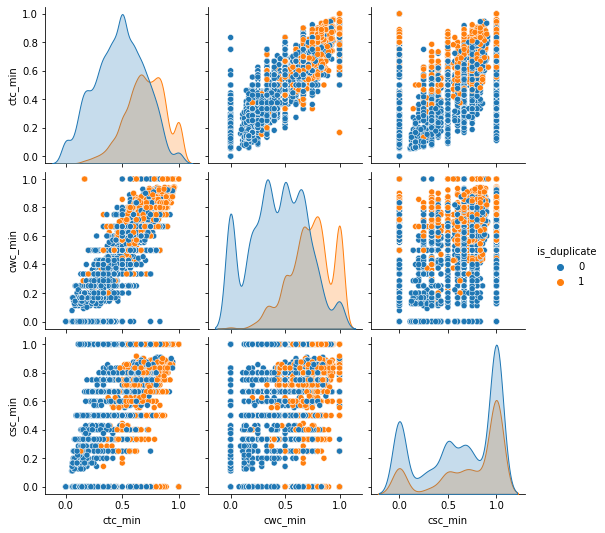

In [34]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

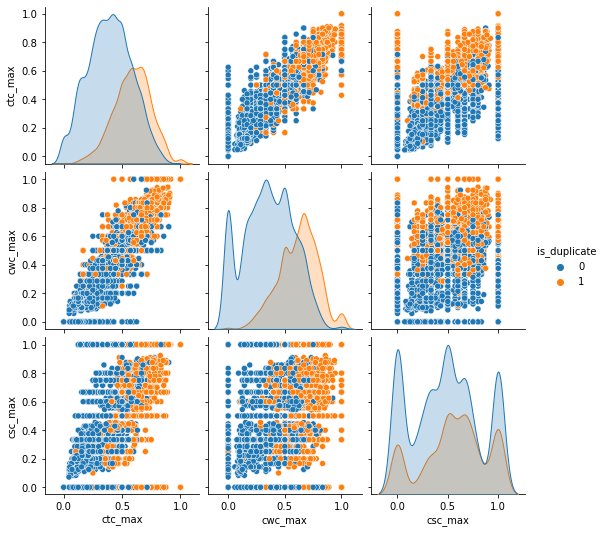

In [35]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

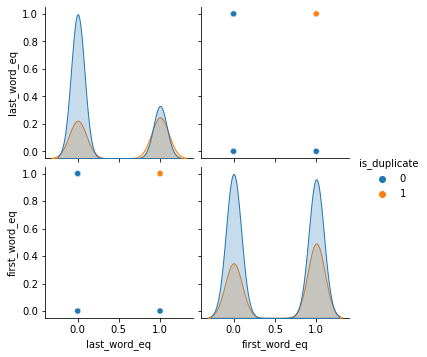

In [36]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

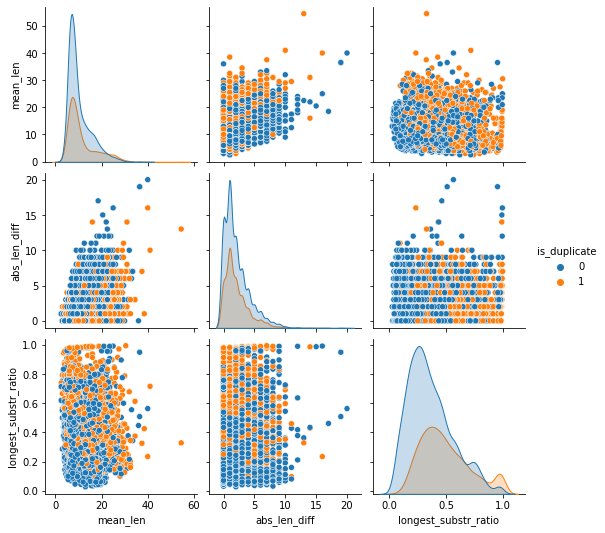

In [37]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

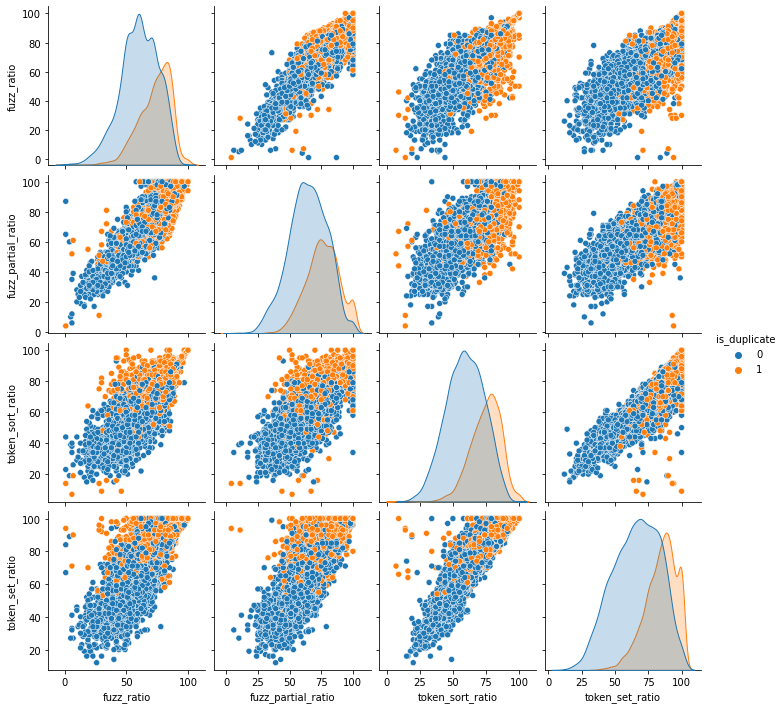

In [38]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

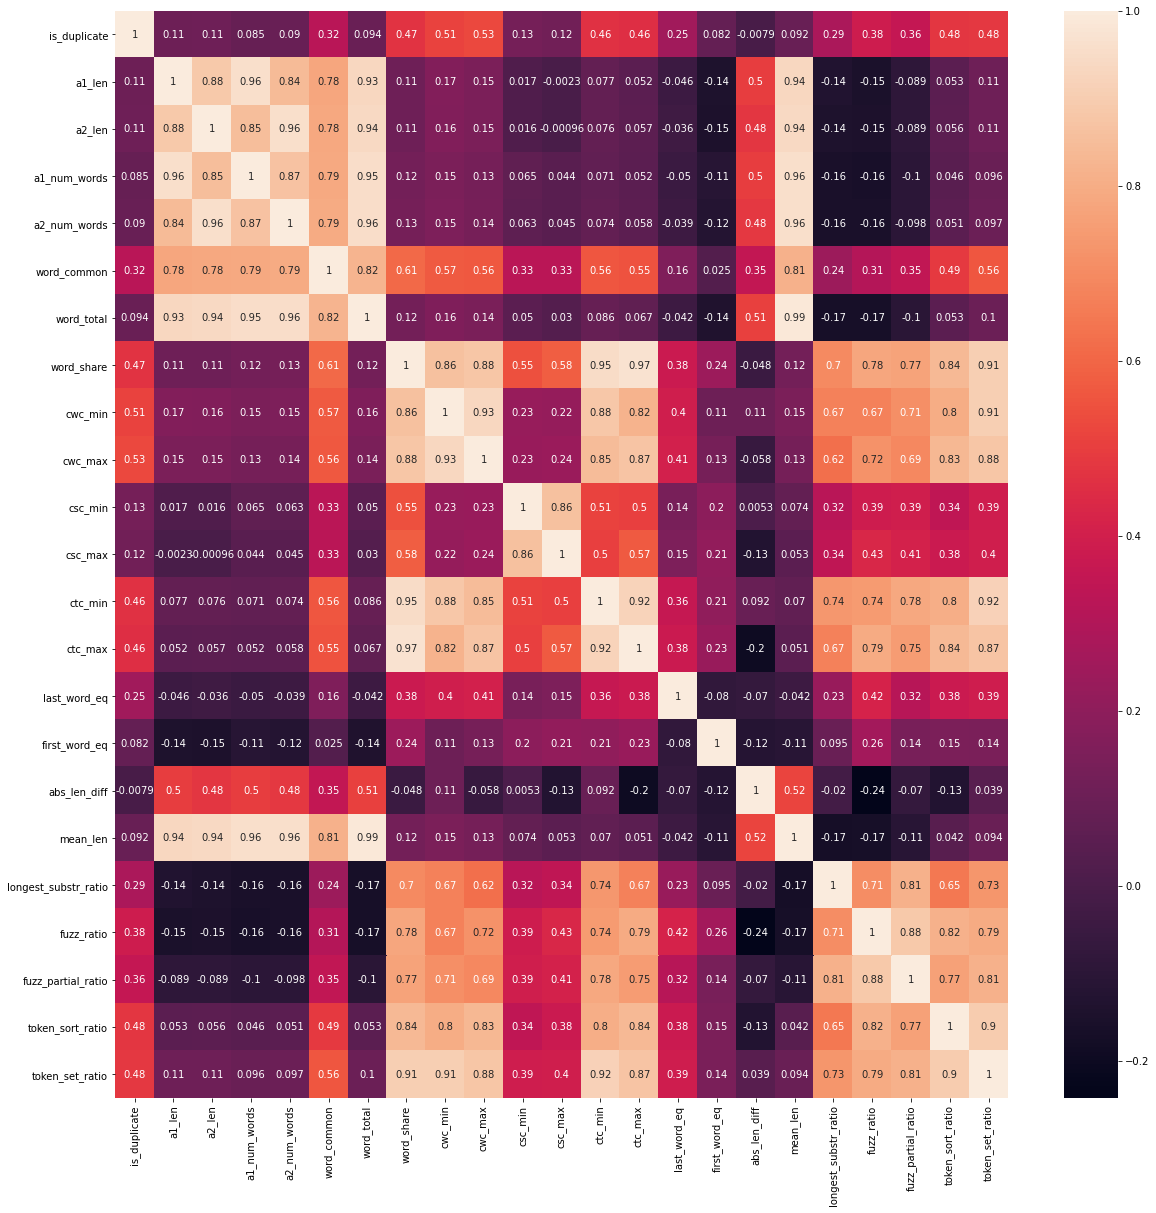

In [39]:
P = new_df.drop(labels=['answer1','answer2'], axis = 1)
plt.subplots(figsize=(20, 20))
sns.heatmap(P.corr(), annot=True, cmap="rocket")
plt.show()

In [40]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

In [41]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7249 samples in 0.042s...
[t-SNE] Computed neighbors for 7249 samples in 0.625s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7249
[t-SNE] Computed conditional probabilities for sample 2000 / 7249
[t-SNE] Computed conditional probabilities for sample 3000 / 7249
[t-SNE] Computed conditional probabilities for sample 4000 / 7249
[t-SNE] Computed conditional probabilities for sample 5000 / 7249
[t-SNE] Computed conditional probabilities for sample 6000 / 7249
[t-SNE] Computed conditional probabilities for sample 7000 / 7249
[t-SNE] Computed conditional probabilities for sample 7249 / 7249
[t-SNE] Mean sigma: 0.144612
[t-SNE] Computed conditional probabilities in 0.256s
[t-SNE] Iteration 50: error = 87.6877289, gradient norm = 0.0323364 (50 iterations in 2.749s)
[t-SNE] Iteration 100: error = 72.9283295, gradient norm = 0.0070709 (50 iterations in 2.188s)
[t-SNE] Iteration 150: error = 70.0957565, gradient norm = 0

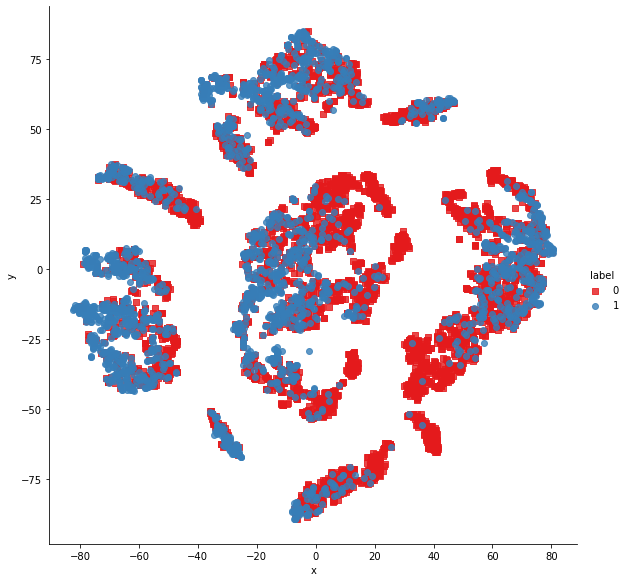

In [42]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])

In [43]:
ques_df = new_df[['answer1','answer2']]
ques_df.head()

,answer1,answer2
0,a plane is taking off,an air plane is taking off
1,a man is playing a large flute,a man is playing a flute
2,a man is spreading shreded cheese on a pizza,a man is spreading shredded cheese on an uncoo...
3,three men are playing chess,two men are playing chess
4,a man is playing the cello,a man seated is playing the cello


In [44]:
final_df = new_df.drop(columns=['answer1','answer2'])
print(final_df.shape)
final_df.head()

(7249, 23)


,is_duplicate,a1_len,a2_len,a1_num_words,a2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,1,21,26,5,6,4,11,0.36,0.999950,0.666644,...,0.666656,1,0,1,5.5,0.909091,89,95,89,95
1,1,30,24,7,6,5,11,0.45,0.999967,0.749981,...,0.714276,1,1,1,6.5,0.760000,89,88,89,100
2,1,44,55,9,10,7,18,0.39,0.799984,0.666656,...,0.699993,1,1,1,9.5,0.533333,89,89,89,89
3,0,27,25,5,5,4,10,0.40,0.749981,0.749981,...,0.799984,1,0,0,5.0,0.846154,88,88,88,91
4,1,26,33,6,7,6,13,0.46,0.999967,0.749981,...,0.857131,1,1,1,6.5,0.777778,88,85,88,100


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
# merge texts
questions = list(ques_df['answer1']) + list(ques_df['answer2'])

Tfidf = TfidfVectorizer(max_features=3000)
a1_arr, a2_arr = np.vsplit(Tfidf.fit_transform(questions).toarray(),2)

In [46]:
temp_df1 = pd.DataFrame(a1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(a2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(7249, 6000)

In [47]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(7249, 6023)


,is_duplicate,a1_len,a2_len,a1_num_words,a2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,1,21,26,5,6,4,11,0.36,0.999950,0.666644,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,24,7,6,5,11,0.45,0.999967,0.749981,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,44,55,9,10,7,18,0.39,0.799984,0.666656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,27,25,5,5,4,10,0.40,0.749981,0.749981,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,26,33,6,7,6,13,0.46,0.999967,0.749981,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Buildinga

In [48]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=42)

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [50]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
abc = AdaBoostClassifier(n_estimators=50, random_state=42)
bc = BaggingClassifier(n_estimators=50, random_state=42)
etc = ExtraTreesClassifier(n_estimators=50, random_state=42)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=42)
xgb = XGBClassifier(n_estimators=50,random_state=42)

In [51]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [52]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,f1_score, recall_score

In [53]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    f1_scores = f1_score(y_test,y_pred)
    recall_scores = recall_score(y_test,y_pred)
    
    return accuracy,precision,f1_scores, recall_scores

In [54]:
accuracy_scores = []
precision_scores = []
f1_score_scores = []
recall_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision, current_f1_score, current_recall_score = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print("f1_score - ",current_f1_score)
    print("recall_score - ",current_recall_score)
    print("--------------------------------------------------------")
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    f1_score_scores.append(current_f1_score)
    recall_scores.append(current_recall_score)

For  SVC
Accuracy -  0.6413793103448275
Precision -  0.0
f1_score -  0.0
recall_score -  0.0
--------------------------------------------------------
For  KN
Accuracy -  0.7268965517241379
Precision -  0.6483253588516746
f1_score -  0.5778251599147122
recall_score -  0.5211538461538462
--------------------------------------------------------
For  NB
Accuracy -  0.6406896551724138
Precision -  0.4992481203007519
f1_score -  0.560337552742616
recall_score -  0.6384615384615384
--------------------------------------------------------
For  DT
Accuracy -  0.7841379310344827
Precision -  0.7423887587822015
f1_score -  0.6694825765575502
recall_score -  0.6096153846153847
--------------------------------------------------------
For  LR
Accuracy -  0.7958620689655173
Precision -  0.7413793103448276
f1_score -  0.6991869918699186
recall_score -  0.6615384615384615
--------------------------------------------------------
For  RF
Accuracy -  0.7993103448275862
Precision -  0.7759036144578313
f1_s

In [55]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores, 'f1_score': f1_score_scores, 'recall_score' : recall_scores }).sort_values('f1_score',ascending=False)

performance_df

,Algorithm,Accuracy,Precision,f1_score,recall_score
4,LR,0.795862,0.741379,0.699187,0.661538
5,RF,0.799310,0.775904,0.688770,0.619231
10,xgb,0.792414,0.752887,0.684155,0.626923
6,AdaBoost,0.785517,0.726681,0.682977,0.644231
9,GBDT,0.796552,0.780549,0.679696,0.601923
7,BgC,0.793793,0.775561,0.675353,0.598077
3,DT,0.784138,0.742389,0.669483,0.609615
8,ETC,0.785517,0.763224,0.660851,0.582692
1,KN,0.726897,0.648325,0.577825,0.521154
2,NB,0.640690,0.499248,0.560338,0.638462


# Hyperparameter Tuning

## HyperTune Xgb Classifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(random_state=42)

In [ ]:
# A parameter grid for XGBoost
params = {
    'learning_rate':[1,0.5,0.1,0.01,0.001],
    'n_estimators':[10,50,100,200],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [6, 7, 8]
    }

In [ ]:
folds = 3

kfolds = KFold(n_splits = folds, shuffle = True, random_state = 4)

random_search = RandomizedSearchCV(xgb, param_distributions=params, scoring='roc_auc', n_jobs=4, cv=kfolds.split(X_train,y_train), verbose=3, random_state=42)

# Here we go
random_search.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f5db2269350>,
                   estimator=XGBClassifier(random_state=42), n_jobs=4,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [1, 0.5, 0.1, 0.01,
                                                          0.001],
                                        'max_depth': [6, 7, 8],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [10, 50, 100, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [ ]:
print(random_search.best_params_)

{'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.6}


## HyperTune Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:

grid_param = {
    "n_estimators" : [90,100,115,130],
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(2,20,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'max_features' : ['auto','log2']
}

In [ ]:
RF_clf = RandomForestClassifier(random_state=42)

In [ ]:
folds = 3

kfolds = KFold(n_splits = folds, shuffle = True, random_state = 42)

random_search_rf = RandomizedSearchCV(RF_clf, param_distributions=grid_param, scoring='roc_auc', n_jobs=4, cv=kfolds.split(X_train,y_train), verbose=3, random_state=42)

# Here we go
random_search_rf.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f5db226ddd0>,
                   estimator=RandomForestClassifier(random_state=42), n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 20),
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 10),
                                        'n_estimators': [90, 100, 115, 130]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [ ]:
print(random_search_rf.best_params_)

{'n_estimators': 115, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 13, 'criterion': 'entropy'}


## HyperTune Logistic Regression Classifier

In [ ]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [ ]:
LR = LogisticRegression()

In [ ]:
folds = 3

kfolds = KFold(n_splits = folds, shuffle = True, random_state = 42)

random_search_lr = RandomizedSearchCV(LR, param_distributions=param_grid, scoring='roc_auc', n_jobs=4, cv=kfolds.split(X_train,y_train), verbose=3, random_state=42)

# Here we go
random_search_lr.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f5db22e9e50>,
                   estimator=LogisticRegression(), n_jobs=4,
                   param_distributions=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                         'max_iter': [100, 1000, 2500, 5000],
                                         'penalty': ['l1', 'l2', 'elasticnet',
                                                     'none'],
                                         'solver': ['lbfgs', 'newton-cg',
                                                    'liblinear', 'sag',
                                                    'saga']}],
                   random_state

In [ ]:
print(random_search_lr.best_params_)

{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 5000, 'C': 0.012742749857031334}


## Hyperparameter Tuned Model

In [56]:
from sklearn.ensemble import VotingClassifier

In [57]:
# Voting Classifier
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
xgb = XGBClassifier(subsample =  1.0, n_estimators =  100, min_child_weight = 10, max_depth = 8, learning_rate = 0.1, gamma = 1, colsample_bytree = 0.6)
lrc = LogisticRegression(solver='liblinear', penalty='l1')

In [58]:
voting = VotingClassifier(estimators=[('RF', rfc), ('XGB', xgb), ('LR', lrc)],voting='soft')

In [59]:
voting.fit(X_train,y_train)

[15:39:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=42)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6, gamma=1,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1,
                                            max_delta_step=None, max_depth=8,
                                            min_child_weight=10, missing=nan,
                                            monotone_constraints=None,
                                            n_estimator

In [60]:
y_pred = voting.predict(X_test)
print("Test Accuracy",accuracy_score(y_test,y_pred))
print("f1 score",f1_score(y_test,y_pred))

Test Accuracy 0.8075862068965517
f1 score 0.7072402938090242


In [61]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       930
           1       0.78      0.65      0.71       520

    accuracy                           0.81      1450
   macro avg       0.80      0.77      0.78      1450
weighted avg       0.81      0.81      0.80      1450



In [62]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
cm

array([[834,  96],
       [183, 337]], dtype=int64)

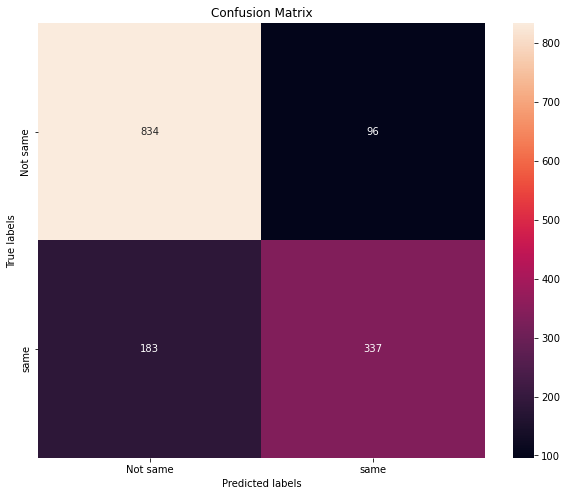

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt     
plt.figure(figsize= (10,8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not same', 'same']); ax.yaxis.set_ticklabels(['Not same', 'same']);

# Save Model

In [64]:
# taken the model with highest Accuracy and Precision 
import pickle
pickle.dump(Tfidf,open('Tfidf_vectorizer.pkl','wb'))
pickle.dump(voting ,open('model5.pkl','wb'))